C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


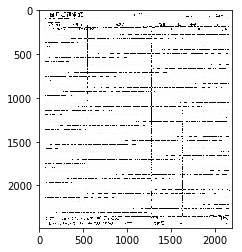

In [11]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

import skimage
import imutils
from imutils import contours
from tqdm import tqdm
import pandas as pd

# from PIL import Image, ImageDraw,ImageFont
# import os
# import sys
# from statistics import median
# import pyocr
# import pyocr.builders
# from pdf2image import convert_from_path
# import cv2 
# import numpy as np


img = cv2.imread("002.jpg")
kernel = np.ones((20,20),np.uint8)
img_erode = cv2.erode(img,kernel,iterations = 3)

out_e = cv2.cvtColor(img_erode, cv2.COLOR_BGR2GRAY)
ret, out_e_thresh_bin = cv2.threshold(out_e, 120, 255, cv2.THRESH_BINARY_INV)
out_e_thresh_bin_nonoise = cv2.morphologyEx(out_e_thresh_bin,cv2.MORPH_OPEN,kernel, iterations = 2)
out_e_thresh_bin_e = cv2.erode(out_e_thresh_bin_nonoise, None, iterations=4)

plt.imshow(out_e_thresh_bin_e, "gray")


"""Connected-component analysis of image"""

def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

labels = skimage.measure.label(out_e_thresh_bin_e, neighbors=8, background=0)
mask = np.zeros(out_e_thresh_bin_e.shape, dtype="uint8")
labels
 
# loop over the unique components
def img_size(img):
    return img.shape[0]*img.shape[1]

img_size = img_size(img)
for label in np.unique(labels):
# if this is the background label, ignore it
    if label == 0:
        continue
 
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(out_e_thresh_bin_e.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > img_size*1/1000:
        cnts_mask_all = cv2.findContours(labelMask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts_mask = grab_contours(cnts_mask_all)
        cnts_mask = contours.sort_contours(cnts_mask)[0]
        contour_size = []
        for i, c in enumerate(cnts_mask):
            (x,y,w,h) = cv2.boundingRect(c)
            contour_size.append((x+w)*(y+h))
        if np.max(contour_size) <= img_size*90/100:
            mask = cv2.add(mask, labelMask)
    else:
        continue
cnts_allinfo = cv2.findContours(mask.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnts = grab_contours(cnts_allinfo)
cnts = contours.sort_contours(cnts)[0]

counter = 0
img_dict = {}
for (i, c) in enumerate(cnts):
    #draw bright spots on image
    (x, y ,w, h) = cv2.boundingRect(c)
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255),2)
    img_crop = img.copy()[y:y+h,x:x+w,:]
    img_dict[counter] = img_crop
#     cv2.imwrite(".\\test_cut\\" + "002" +"_part_" + str(counter) + ".jpg", img_crop)
#     counter = counter + 1
# # cv2.imwrite(img_path.split("\\")[-1].split(".")[0] + "_test_connectComponent_graph.jpg", img)

#            # mask = cv2.add(mask,LabelMask)
# #             print((x+w)*(y+h))
#         #mask = cv2.add(mask, labelMask)
# plt.figure(figsize = (20,20))
# plt.imshow(mask.copy())

max_part = []
for i, p in img_dict.items():
    if max_part == [] or p.shape[0]*p.shape[1]>max_part.shape[0]*max_part.shape[1]:
        max_part = p
    else:
        max_part = max_part
cv2.imwrite(".\\test_cut\\" + "002" +"_part_" + str(counter) + ".jpg", max_part)